In [1]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import skimage
%matplotlib inline

In [2]:
scans_path = "/Users/alex/Downloads/IR_140/" # TODO: Change this to match where your data is located!
list_of_scans = os.listdir(scans_path)
print(list_of_scans)

['ST-3140451203929640674', 'Segmentation RT 140', '.DS_Store', 'Segmentation LT 140', '__guests.xml', 'ST-1477081569257469592', '__index.xml', 'ST-7348309129696896694']


In [3]:
# for figuring out the controls lets experiment with slice 122 of slice 2
scan_num = 0
scan_path = os.path.join(scans_path, list_of_scans[scan_num])
list_of_slices = os.listdir(scan_path)

slice_num = 42
slice_path = os.path.join(scan_path,list_of_slices[slice_num])

# read in the full path to the file as ds
ds=pydicom.read_file(slice_path) # you may have to use pydicom instead of dicom 
print(ds)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.70.1.234677878226661102645431682207988696018
(0008, 0020) Study Date                          DA: '20110527'
(0008, 0030) Study Time                          TM: '065014'
(0008, 0050) Accession Number                    SH: '2615788742648199'
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'Unknown manufacturer'
(0008, 0090) Referring Physician's Name          PN: ' '
(0008, 103e) Series Description                  LO: 'No series description'
(0008, 1090) Manufacturer's Model Name           LO: 'Unknown model'
(0010, 0010) Patient's Name                      PN: '549698'
(0010, 0020) Patient ID                          LO: '2607042395'


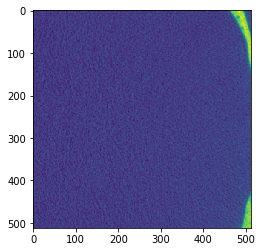

(<type 'numpy.ndarray'>, 30.511024475097656, dtype('int16'))


In [4]:
rawimg= ds.pixel_array
plt.imshow(rawimg, cmap='viridis')
plt.show()
print(type(rawimg), np.mean(ds.pixel_array), rawimg.dtype)

In [5]:
def get_stats(arr):
    return (np.max(arr), np.min(arr), np.mean(arr), np.std(arr))

def convertHU(ds):
    # get the raw slice data
    img_raw = ds.pixel_array

    # HU conversion
    resc_slope = ds.RescaleSlope
    resc_int = ds.RescaleIntercept
    img_hu = resc_slope*np.array(img_raw) + resc_int
    
    return (img_raw, img_hu)


In [6]:
ds=pydicom.read_file(slice_path) 

# get the raw slice data and the converted HU array
img_raw, img_hu = convertHU(ds)

# computation of max, min, mean, stdev
(max_raw, min_raw, mean_raw, stdev_raw) = get_stats(img_raw)
(max_hu, min_hu, mean_hu, stdev_hu) = get_stats(img_hu)

# print it out 
print ("Raw data:")
print (max_raw, min_raw, mean_raw, stdev_raw)
print ("Hounsfield Units")
print (max_hu, min_hu, mean_hu, stdev_hu)

Raw data:
(2132, -457, 30.511024475097656, 194.40743779426978)
Hounsfield Units
(2132.0, -457.0, 30.511024475097656, 194.40743779426978)


In [7]:
def assemble_volume(scan_path):
    '''
    input: 
        * scan_path, a path to the slices for a single CT scan
    
    output: 
        * vol_raw, a three-dimensional np array containing the raw pixel arrays 
        * vol_hu, a three-dimensional np array w/ rescaling to HU 
    
    '''
    print("Assembling volume from directory: ")
    print(scan_path)
    list_of_slices = os.listdir(scan_path)
    
    slice_path = os.path.join(scan_path,list_of_slices[0])
    ds1=pydicom.read_file(slice_path, force=True) 
    (l, w) = np.array(ds1.pixel_array).shape
    
    NumSlices = len(list_of_slices)
    
    vol_raw = np.zeros((l, w, NumSlices))
    vol_hu = np.zeros((l, w, NumSlices))
    
    idx_list = []
    for i, section in enumerate(list_of_slices):
        ds = pydicom.read_file(os.path.join(scan_path, section), force=True)
        idx_list.append((ds.InstanceNumber, i))

    idx_list = sorted(idx_list, key=lambda tup: tup[0])

    for pos, (_, i) in enumerate(idx_list):
        ds = pydicom.read_file(os.path.join(scan_path, list_of_slices[i]), force=True)
        img_raw, img_hu = convertHU(ds)
        vol_raw[:,:,pos] = img_raw
        vol_hu[:,:,pos] = np.array(img_hu)
        
    return (vol_raw, vol_hu)
    

In [8]:
def do_subplots(vol, spacing=None):
    fig, ax = plt.subplots(5,5)
    for i in range(5):
        for j in range(5):
            ax[i,j].imshow(vol[:,:,(5*i+j)*15])
            ax[i,j].axis('off')
    plt.rcParams['figure.figsize']=(30,18)
    plt.show()

In [9]:
vol_raw, vol_hu = assemble_volume(scan_path)

do_subplots(vol_raw)


Assembling volume from directory: 
/Users/alex/Downloads/IR_140/ST-3140451203929640674


AttributeError: 'FileDataset' object has no attribute 'InstanceNumber'

In [ ]:
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

# Get ref file
RefDs = dicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

# The array is sized based on 'ConstPixelDims'
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = dicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

In [10]:
import vtk 
from vtk.util import numpy_support as nps

In [11]:
path_dicom = "/Users/alex/Downloads/IR_140/ST-3140451203929640674"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(path_dicom)
reader.Update()

In [12]:
# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()
# Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()
# Get the 'vtkPointData' object from the 'vtkImageData' object
pointData = imageData.GetPointData()
# Ensure that only one array exists within the 'vtkPointData' object
assert (pointData.GetNumberOfArrays()==1)
# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
arrayData = pointData.GetArray(0)

# Convert the `vtkArray` to a NumPy array
ArrayDicom = nps.vtk_to_numpy(arrayData)
# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')

In [15]:
imageData.GetPoints()

AttributeError: GetPoints

In [13]:
print ArrayDicom.shape
print np.min(ArrayDicom), np.max(ArrayDicom)

(512, 512, 504)
-1024 2586


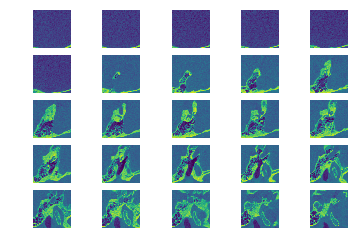

In [14]:
do_subplots(ArrayDicom)

(array([6.847700e+04, 2.920800e+04, 1.741600e+04, 1.651600e+04,
        1.191900e+04, 7.720000e+03, 9.583000e+03, 6.552000e+03,
        8.611000e+03, 8.548000e+03, 6.588000e+03, 8.820000e+03,
        6.948000e+03, 9.415000e+03, 9.719000e+03, 7.543000e+03,
        1.024200e+04, 8.217000e+03, 1.139500e+04, 1.175300e+04,
        9.019000e+03, 1.255300e+04, 1.299500e+04, 1.019400e+04,
        1.370200e+04, 1.065000e+04, 1.476500e+04, 1.520500e+04,
        1.176600e+04, 1.639300e+04, 1.254800e+04, 1.754500e+04,
        1.804700e+04, 1.406000e+04, 1.913400e+04, 1.496100e+04,
        2.051700e+04, 2.128800e+04, 1.635100e+04, 2.228700e+04,
        2.331400e+04, 1.799500e+04, 2.444100e+04, 1.902400e+04,
        2.598900e+04, 2.670700e+04, 2.036200e+04, 2.788900e+04,
        2.173400e+04, 2.997200e+04, 3.060800e+04, 2.348400e+04,
        3.175100e+04, 2.445100e+04, 3.342000e+04, 3.476300e+04,
        2.654300e+04, 3.601600e+04, 2.756000e+04, 3.758600e+04,
        3.866900e+04, 2.992700e+04, 4.00

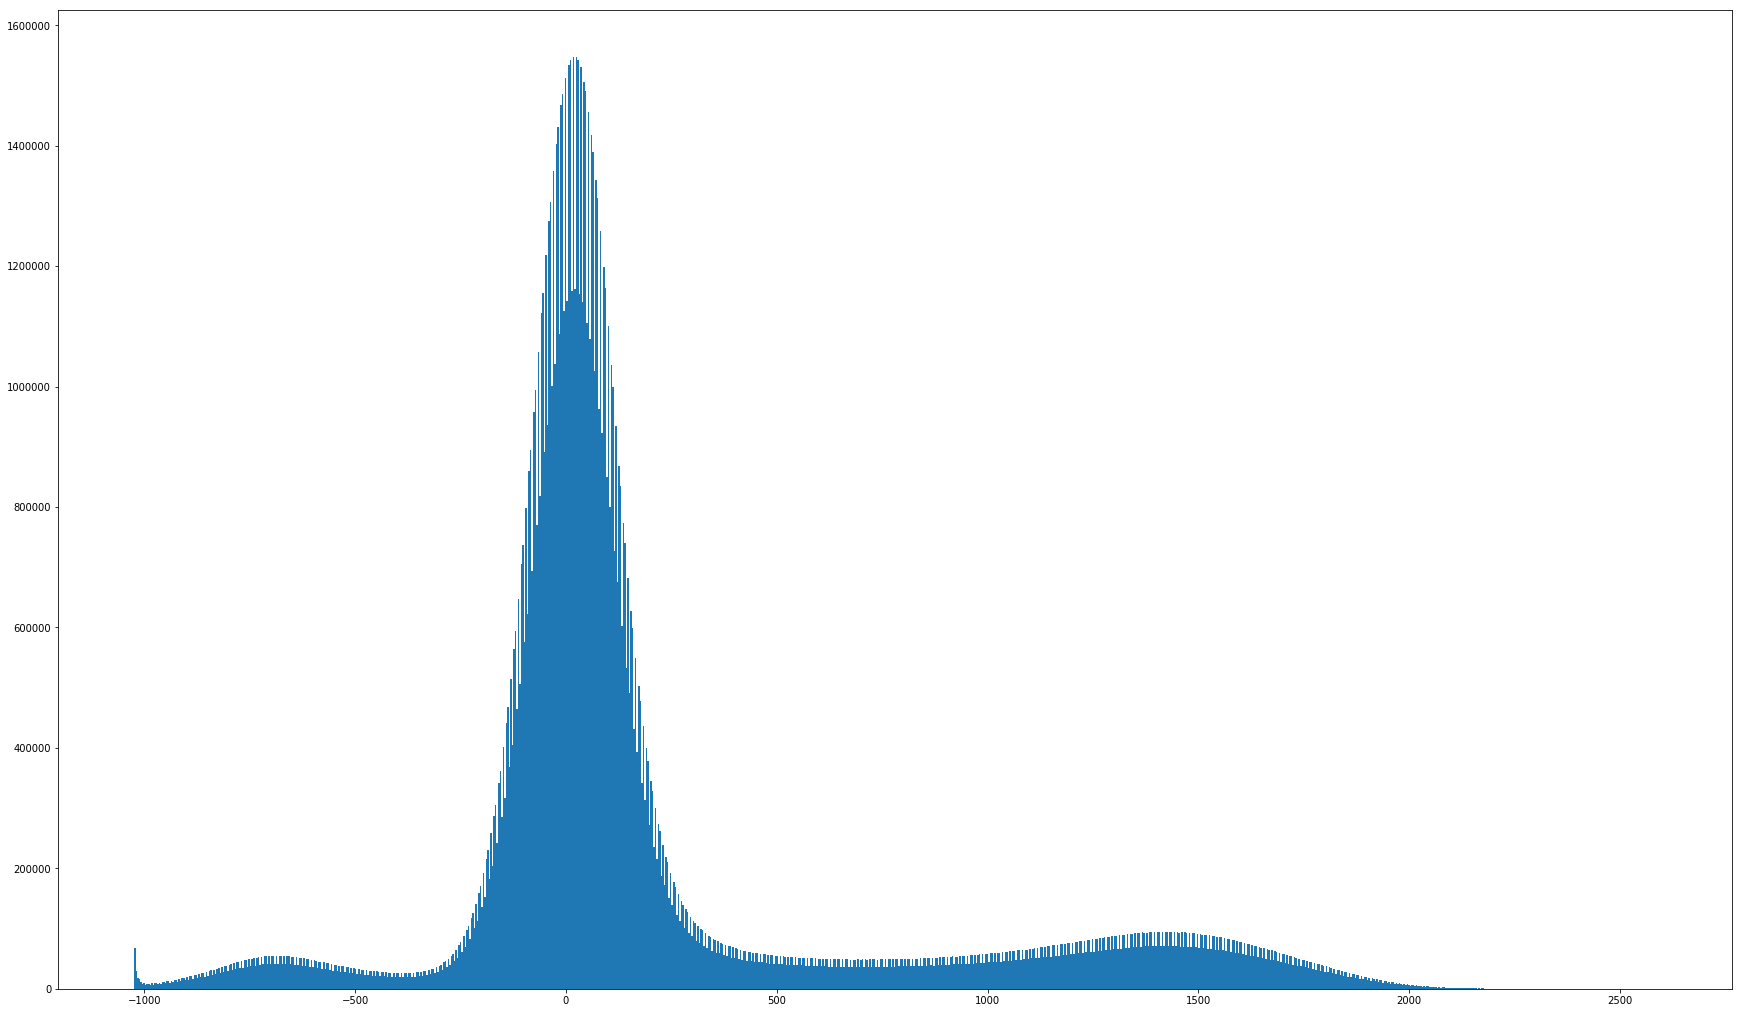

In [33]:
plt.hist(ArrayDicom.reshape([-1]), 1000)